In [1]:
%load_ext autoreload
%autoreload 2

import math
import sys
sys.path.append('../')

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
# genff imports
from genff.data_handling.dataset import GroupDataset
from genff.data_handling.transform import RectangularAngle
from genff.opt_method.opt_generator import opt_generator_loss, torch_to_numpy
from genff.visualization.plotting import convert_to_rect_representation

In [3]:
import argparse

# params for warped image creation
def get_params(i): 
    parser = argparse.ArgumentParser(description='Warp data.')
    parser.add_argument('-i', '--input-h5', type=str, required=True,
                        help='input path to h5 file')
    parser.add_argument('-o', '--output-h5', type=str, required=False,
                        help='output path (dflt: input-h5 basename with _warped.h5 extension)',
                        default="")
    parser.add_argument('-v', '--verbose', action="store_true",
                        help='print info?')
    parser.add_argument('-p', '--plot', action="store_true",
                        help='plot maps as they are being generated?')
    parser.add_argument('--no-dyads', action='store_true', default=False,
                        help='skip dyads when making warped samples')

    return parser.parse_args([i])

# Grayscale plotting

In [4]:
def plot_env_grey(env_cropped, individual, context, mask, distro=None, eres=0.25, filename=None):
    offset_x = (env.shape[1] * 0.5) * env_res
    offset_y = (env.shape[0] * 0.5) * env_res
    
    env_np = np.zeros((24,24,3))
    
    env_np[:,:,0] = np.where(env_cropped[:,:,1].detach().numpy() > 0.0, np.ones((24,24)), np.zeros((24,24)))
    env_np[:,:,1] = np.where(env_cropped[:,:,3].detach().numpy() > 0.0, np.ones((24,24)), np.zeros((24,24)))
    env_np[:,:,2] = np.where(env_cropped[:,:,2].detach().numpy() > 0.0, np.ones((24,24)), np.zeros((24,24)))
    
    grayscale_img = np.dot(env_np, [1.0, 2.0, 4.0]) # free, short, tall
    grayscale_img = np.where(grayscale_img == 7.0, np.ones((24,24))*2.0,grayscale_img) # free, short and tall => short
    grayscale_img = np.where(grayscale_img == 6.0, np.ones((24,24))*2.0,grayscale_img) # short and tall => short
    grayscale_img = np.where(grayscale_img == 5.0, 4*np.ones((24,24)),grayscale_img) # free and tall => free
    grayscale_img = np.where(grayscale_img == 3.0, np.ones((24,24))*2.0,grayscale_img) # free and short => short

    grayscale_img = np.where(grayscale_img == 1.0, np.ones((24,24))*0.92,grayscale_img) # free is lightest grey
    grayscale_img = np.where(grayscale_img == 2.0, np.ones((24,24))*0.75,grayscale_img) # short is light grey
    grayscale_img = np.where(grayscale_img == 4.0, np.ones((24,24))*0.58,grayscale_img) # tall is dark grey
    grayscale_img = np.where(grayscale_img == 0.0, np.ones((24,24))*0.41,grayscale_img) # unknown is darkest grey
    
    plt.imshow(grayscale_img, origin='lower', cmap='gray', vmin=0.0, vmax=1.0)
    plt.quiver((offset_x + context[mask.bool(), 0].cpu()) / eres,
               (offset_y + context[mask.bool(), 1].cpu()) / eres,
               context[mask.cpu().bool(), 2].cpu(),
               context[mask.cpu().bool(), 3].cpu(),
               color='darkorange')
    if distro is not None:
        plt.quiver((offset_x + distro[:,0].cpu()) / eres,
                   (offset_y + distro[:,1].cpu()) / eres,
                   distro[:,2].cpu(),
                   distro[:,3].cpu(),
                   color='plum')
    plt.quiver((offset_x + individual[:,0].cpu()) / eres,
           (offset_y + individual[:,1].cpu()) / eres,
           individual[:,2].cpu(),
           individual[:,3].cpu(),
           color='indigo')
    plt.axis('off')
    
    if filename is not None:
        plt.savefig(filename)

# Plot and save original cropped group image

for the figures, we are using Beechwood_1 sample 800, Ihlen_0 sample 2800, Pomaria_2 sample 1500

In [5]:
# get sample from dataset
environment = "env_Beechwood_1_int"
dataset = GroupDataset('../data/igibson_sim_data/' + environment + '.h5')
print(dataset.__dict__.keys())
env_res = dataset.resolution
sample_no = 800
# # args, to pass to warp_one_sample
# args = get_params(['../data/igibson_sim_data/' + environment + '.h5'])

individual, context, mask, env = dataset[sample_no]
new_ind, new_con = convert_to_rect_representation(individual, context, mask, env, angle_index=2)
print(type(individual))
print(individual.shape)
plot_env_grey(env, new_ind, new_con, mask, eres=env_res, 
              filename="simulated_" + environment + "_" + str(sample_no) + ".pdf")


Loading ../data/igibson_sim_data/env_Beechwood_1_int.h5
dict_keys(['num_features', 'rect_repr', 'transform', 'individual', 'context', 'center', 'mask', 'stamps', 'num_examples', 'env', 'env_key', 'env_dict', 'grid_w', 'resolution', 'include_centers'])
<class 'torch.Tensor'>
torch.Size([1, 3])


# Plot and save warped image

In [6]:
from bin.warp_data import warp_one_sample
        
print(individual)
warped_env, warped_ind, warped_con = warp_one_sample(env.detach().cpu().numpy().astype(np.float32), individual, context, env_res, sample_no, None)
warped_ind, warped_con = convert_to_rect_representation(torch.from_numpy(warped_ind), torch.from_numpy(warped_con), mask, torch.from_numpy(warped_env), angle_index=2)
print(warped_con)
print(mask)
plot_env_grey(torch.from_numpy(warped_env), 
              warped_ind, 
              warped_con, 
              np.squeeze(mask), eres=env_res, 
              filename="warped_" + environment + "_" + str(sample_no) + ".pdf")

tensor([[-0.5795, -0.8320,  0.9628]])
tensor([[ 0.1795, -0.9696, -0.2142,  0.9768],
        [ 0.9085, -0.2905, -0.9615,  0.2748],
        [-0.1488,  0.9357,  0.1224, -0.9925],
        [-0.9392,  0.3244,  0.9327, -0.3607],
        [ 0.0000,  0.0000,  0.9682, -0.2503]])
tensor([1., 1., 1., 1., 0.])


# Plot and save angular transformation

tensor([[[ 0.4185, -0.9016, -0.6449,  0.8921],
         [ 0.9529, -0.0562, -1.0005,  0.0255],
         [-0.3801,  0.8761,  0.4877, -0.9303],
         [-0.9912,  0.0816,  1.1076, -0.1158],
         [ 0.0000,  0.0000,  1.6629,  0.0000]]])
tensor([1., 1., 1., 1., 0.])


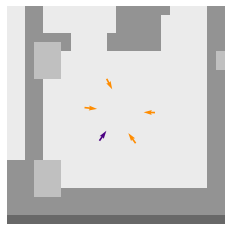

In [7]:
from genff.data_handling.transform import AddNoiseToContextAngles

transform = AddNoiseToContextAngles(sigma=0.349066)
# using unwarped individual, context, and environment
ang_ind, ang_con, ang_mask, ang_env = transform((new_ind, torch.unsqueeze(new_con, 0), mask, env))
print(ang_con)
print(ang_mask)
plot_env_grey(ang_env, 
              ang_ind, 
              np.squeeze(ang_con, axis=0), 
              ang_mask, eres=env_res, 
              filename="ang_" + environment + "_" + str(sample_no) + ".pdf")